# Introduction

> This dataset is , there is a file that contains data describtion

# Libraries :books:

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingRegressor
from xgboost.sklearn import XGBRegressor, XGBRFRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from collections import Counter
import matplotlib.pyplot as plt


# Importing Data

In [2]:
train_path = './data/train.csv'
test_path = './data/test.csv'

train_df = pd.read_csv(train_path)
train_target = train_df.SalePrice

test_df = pd.read_csv(test_path)


# Data Exploration

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

we can see some columns have null values BUT:
* if we reed the data describtion, we will realize that Alley has NA as a real value indicating *No Alley Access* so we should take care and **DON'T** drop it.
* same for FireplaceQu, NA means no Fireplace, so it's **NOT** a missing value so we need to keep it.
* same for Fence, NA means no Fence, it's **NOT** a mising value.
* same for PoolQC, NA means no pool , it's **NOT** a missing value.
* same for MiscFeature, NA means no Miscellaneous features not covered, it's **NOT** a missing value.
* same for ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'] , NA means no Basement, it's **NOT** a missing value.
* same for ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'], NA means no Garage, it's **NOT** a missing value.

but for ['LotFrontage', 'MasVnrType', 'MasVnrArea', 'Electrical','GarageYrBlt'], these columns have missing values so we need to invistigate them further.

## Exploring Missing Values
### LotFrontage

* Describtion: Linear Feet of street connected to property

In [4]:
train_df['LotFrontage'].describe()

count    1201.000000
mean       70.049958
std        24.284752
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64

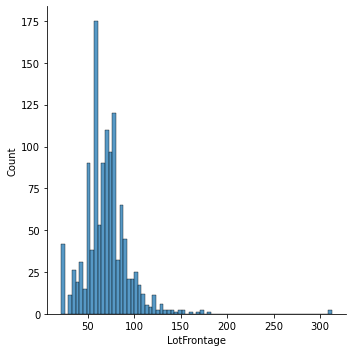

In [5]:
###  LotFrontage

sns.displot(data = train_df, x= 'LotFrontage')

it's numeric column, with right skewed distribution and missing values, so first may be it's better to drop the missing values and apply log to the values to make it normally distribution

In [6]:
train_df['LotShape'].value_counts()

Reg    925
IR1    484
IR2     41
IR3     10
Name: LotShape, dtype: int64

In [7]:
mean_values = train_df.groupby('LotShape')['LotFrontage'].mean()
mean_values

LotShape
IR1     76.094637
IR2     76.500000
IR3    138.428571
Reg     67.038778
Name: LotFrontage, dtype: float64

In [8]:
###  Handle null values 
i = 0
for shape in mean_values.index:
    
    train_df.loc[((train_df['LotFrontage'].isna()) & (train_df['LotShape']==shape)), 'LotFrontage']= mean_values[i]
    test_df.loc[((test_df['LotFrontage'].isna()) & (test_df['LotShape']==shape)), 'LotFrontage']= mean_values[i]
    i+=1


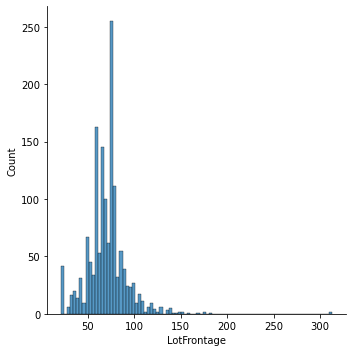

In [9]:
sns.displot(data = train_df, x= 'LotFrontage')

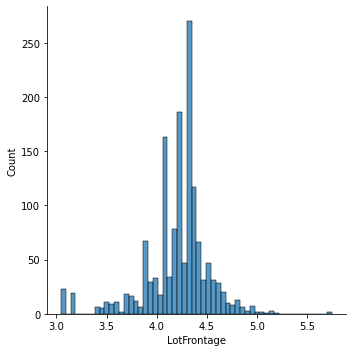

In [10]:
###  apply log to LotFrontage values
train_df['LotFrontage'] = pd.Series(np.log(train_df['LotFrontage']))
sns.displot(data = train_df, x= 'LotFrontage')

**MasVnrType**

In [11]:
train_df['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

we got two columns about Masonry veneer, **MasVnrType** & **MasVnrArea** we need to check that the null values in both of them are in the same rows, if so we can make their area = 0

In [12]:
train_df.loc[train_df['MasVnrType'].isna() == True, 'MasVnrArea']= 0
test_df.loc[test_df['MasVnrType'].isna() == True, 'MasVnrArea']= 0

In [13]:
train_df['MasVnrType'].isna().sum()

8

In [14]:
train_df.loc[train_df['MasVnrType'].isna() == True, 'MasVnrType']= 'None'
test_df.loc[test_df['MasVnrType'].isna() == True, 'MasVnrType']= 'None'


<AxesSubplot:xlabel='MasVnrType', ylabel='count'>

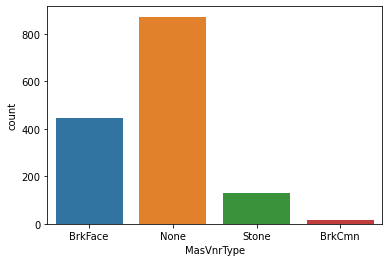

In [15]:
sns.countplot(data = train_df, x = 'MasVnrType')

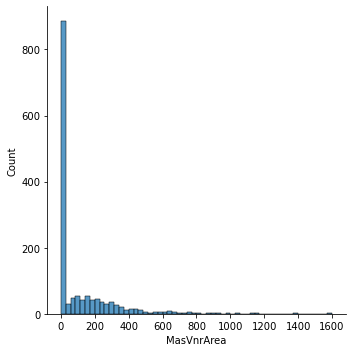

In [16]:
sns.displot(data = train_df, x= 'MasVnrArea')

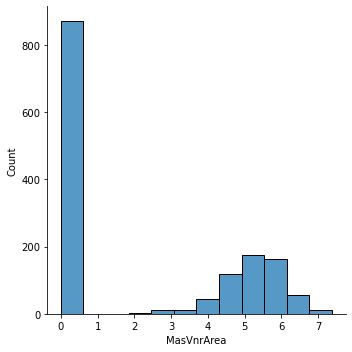

In [17]:
###  apply log to LotFrontage values
train_df.loc[train_df['MasVnrArea']>0,'MasVnrArea'] = pd.Series(np.log(train_df.loc[train_df['MasVnrArea']>0,'MasVnrArea']))
test_df.loc[test_df['MasVnrArea']>0,'MasVnrArea']= pd.Series(np.log(test_df.loc[test_df['MasVnrArea']>0,'MasVnrArea']))

sns.displot(data = train_df, x= 'MasVnrArea')

**Electrical**

In [18]:
train_df[(train_df['Electrical'].isna()==True)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1379,1380,80,RL,4.290459,9735,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,167500


In [19]:
train_df = train_df[(train_df['Electrical'].isna() == False)]
test_df = test_df[(test_df['Electrical'].isna() == False)]

<AxesSubplot:xlabel='Electrical', ylabel='count'>

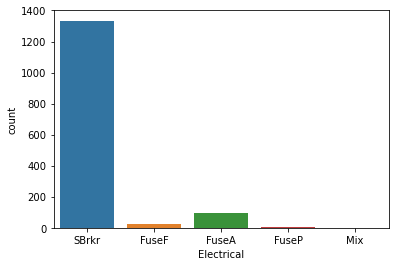

In [20]:
sns.countplot(data = train_df, x = 'Electrical')

In [21]:
train_df.loc[(train_df['Electrical'] != 'SBrkr'), 'Electrical']= 'Not SBrkr'
test_df.loc[(test_df['Electrical'] != 'SBrkr'), 'Electrical']= 'Not SBrkr'

**Garage**

In [22]:
(train_df['GarageType'].isna() & train_df['GarageYrBlt'].isna()).sum()

81

same as MasVnrType, the rows with NA value for GarageType, have missing values in GarageYrBlt, so we can put them = 0

In [23]:
train_df.loc[(train_df['GarageType'].isna() == True, 'GarageYrBlt')]= 0
test_df.loc[(test_df['GarageType'].isna() == True, 'GarageYrBlt')]= 0
#test_df.loc[test_df['GarageYrBlt'].isna() == True, 'GarageYrBlt'] = 0

In [24]:
train_df['GarageYrBlt'].isna().sum()

0

In [25]:
(train_df['GarageType'].isna() & train_df['GarageYrBlt'].isna()).sum()

0

<AxesSubplot:xlabel='MSSubClass', ylabel='count'>

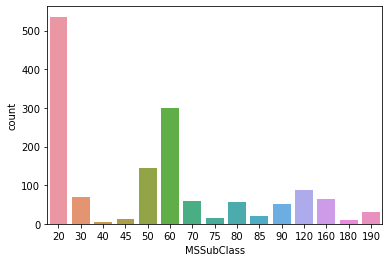

In [26]:
sns.countplot(data = train_df, x = 'MSSubClass')

**It seems like all the above columns have missing values, but if we read the data explanation we can see that NA is treated in some features as a categorical value.
so we need to encode these catecgorical features first before we handle the missing values**

In [27]:
def encoding(data):
    for col in data.columns:
        if (data[col].dtype == 'object'):
            data[col] = pd.Categorical(data[col])
            data[col] = data[col].cat.codes
            if (len(data[data[col]== -1]) !=0):
                data[col] = data[col] + 1
    return data

In [28]:
train_df = encoding(train_df)
test_df = encoding(test_df)

In [29]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,4.174387,8450,1,0,3,3,0,...,0,0,0,0,0,2,2008,8,4,208500
1,2,20,3,4.382027,9600,1,0,3,3,0,...,0,0,0,0,0,5,2007,8,4,181500
2,3,60,3,4.219508,11250,1,0,0,3,0,...,0,0,0,0,0,9,2008,8,4,223500
3,4,70,3,4.094345,9550,1,0,0,3,0,...,0,0,0,0,0,2,2006,8,0,140000
4,5,60,3,4.430817,14260,1,0,0,3,0,...,0,0,0,0,0,12,2008,8,4,250000


In [30]:
train_df.isna().sum().sum()

0

In [31]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   int8   
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   int8   
 6   Alley          1459 non-null   int8   
 7   LotShape       1459 non-null   int8   
 8   LandContour    1459 non-null   int8   
 9   Utilities      1459 non-null   int8   
 10  LotConfig      1459 non-null   int8   
 11  LandSlope      1459 non-null   int8   
 12  Neighborhood   1459 non-null   int8   
 13  Condition1     1459 non-null   int8   
 14  Condition2     1459 non-null   int8   
 15  BldgType       1459 non-null   int8   
 16  HouseStyle     1459 non-null   int8   
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [32]:
train_df = train_df.drop('Id', axis = 1)

<AxesSubplot:>

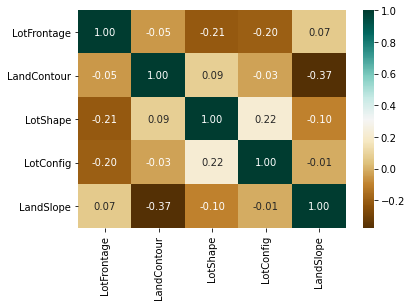

In [33]:
sns.heatmap(train_df[['LotFrontage', 'LandContour', 'LotShape', 'LotConfig', 'LandSlope']].corr(), cmap = 'BrBG', fmt = '.2f', annot = True)

def lotFront_nanVal(data):
    nan_index = data[data['LotFrontage'].isnull()].index
    print("Number of nan values: ", len(nan_index))
    for i in nan_index:

        aveg = None
        td = data[(data['LotConfig'].iloc[i] == data['LotConfig']) # mask of SibSp values in train_data with same value of ith raw SibSp value
                                & (data['LotShape'].iloc[i] == data['LotShape'])].index

        aveg = data.loc[td , 'LotFrontage'].dropna().mean()
        # if these values were unique then aveg won't have a value
        # so we substitue with the median of all Age values
        if not np.isnan(aveg):
            data.loc[i, 'LotFrontage'] = aveg
        else:
            r =  data['LotFrontage'].dropna().mean()
            data.loc[i, 'LotFrontage'] = r
    return data

In [34]:
train_df['LotFrontage'].isnull().sum()

0

def MasVnrArea_nanVal(data):
    nan_index = data[data['MasVnrArea'].isnull()].index
    nan_index.append((data['MasVnrArea'] == 0).index)
    print("Number of nan values: ", len(nan_index))
    for i in nan_index:

        aveg = None
        td = data[(data['MasVnrType'].iloc[i] == data['MasVnrType'])].index

        aveg = data.loc[td , 'MasVnrArea'].dropna().mean()
        # if these values were unique then aveg won't have a value
        # so we substitue with the median of all Age values
        if not np.isnan(aveg):
            data.loc[i, 'MasVnrArea'] = aveg
        else:
            r =  data['MasVnrArea'].dropna().mean()
            data.loc[i, 'MasVnrArea'] = r
    return data

train_df ['LotFrontage'] = train_df['LotFrontage'].fillna(train_df['LotFrontage'].dropna().median())
#train_df = MasVnrArea_nanVal(train_df)
train_df ['MasVnrArea'] = train_df['MasVnrArea'].fillna(train_df['MasVnrArea'].dropna().median())
train_df ['GarageYrBlt'] = train_df['GarageYrBlt'].fillna(train_df['GarageYrBlt'].dropna().median())



In [35]:
y = train_df['SalePrice']

In [36]:
print(len(train_df.columns))

80


In [37]:
train_df.drop('SalePrice', axis =1, inplace = True)

In [38]:
pca = PCA(n_components = 40)
pca.fit(train_df)

x = pca.transform(train_df)

In [39]:
X_train, X_val, y_train, y_val = train_test_split(x, y, random_state = 0, test_size = 0.12)
print(len(y_train), len(y_val))

1283 176


sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_val = sc.transform(X_val)

In [40]:
vr = XGBRegressor(random_state = 0, max_depth = 15).fit(X_train, y_train)
#lr6 = GradientBoostingRegressor(random_state = 0).fit(X_train, y_train)
lr7 = XGBRFRegressor(random_forest = 0, max_depth = 20).fit(X_train, y_train)
#lr7 = HistGradientBoostingRegressor(max_depth = 5).fit(X_train, y_train)

vr = VotingRegressor(estimators = [ ('xgbrfr', lr7), ('xgbregressor', vr)]).fit(X_train, y_train)
pred = vr.predict(X_val)
#pred = lr4.predict(X_val)
print(np.sqrt(mean_squared_error(y_val,pred)))

[05:14:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { random_forest } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[05:14:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/learner.cc:516: 
Parameters: { random_forest } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


34152.536444315025


In [41]:
#test_df = encoding(test_df)
test_df ['LotFrontage'] = test_df['LotFrontage'].fillna(test_df['LotFrontage'].dropna().mean())
test_df ['MasVnrArea'] = test_df['MasVnrArea'].fillna(test_df['MasVnrArea'].dropna().mean())
test_df ['BsmtFinSF1'] = test_df['BsmtFinSF1'].fillna(test_df['BsmtFinSF1'].dropna().mean())

test_df ['GarageYrBlt'] = test_df['GarageYrBlt'].fillna(test_df['GarageYrBlt'].dropna().mean())




In [42]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   int8   
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   int8   
 6   Alley          1459 non-null   int8   
 7   LotShape       1459 non-null   int8   
 8   LandContour    1459 non-null   int8   
 9   Utilities      1459 non-null   int8   
 10  LotConfig      1459 non-null   int8   
 11  LandSlope      1459 non-null   int8   
 12  Neighborhood   1459 non-null   int8   
 13  Condition1     1459 non-null   int8   
 14  Condition2     1459 non-null   int8   
 15  BldgType       1459 non-null   int8   
 16  HouseStyle     1459 non-null   int8   
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [43]:
test_df.loc[test_df['BsmtHalfBath'].isna(),'BsmtHalfBath']=0
test_df.loc[test_df['BsmtFullBath'].isna(),'BsmtFullBath']=0

In [44]:
test_df.loc[test_df['GarageCars'].isna(),'GarageCars']=0

In [45]:
Ids = test_df.Id
test_df = test_df.drop('Id' , axis = 1)

print(test_df.isnull().sum().sum())

print(test_df.columns[test_df.isnull().sum() !=0])

In [46]:
test_df ['TotalBsmtSF'] = test_df['TotalBsmtSF'].fillna(test_df['TotalBsmtSF'].dropna().median())
test_df ['GarageArea'] = test_df['GarageArea'].fillna(test_df['GarageArea'].dropna().median())
test_df ['BsmtFinSF2'] = test_df['BsmtFinSF2'].fillna(test_df['BsmtFinSF2'].dropna().median())
test_df ['BsmtUnfSF'] = test_df['BsmtUnfSF'].fillna(test_df['BsmtUnfSF'].dropna().median())
test_df ['BsmtFullBath'] = test_df['BsmtFullBath'].fillna(test_df['BsmtFullBath'].dropna().median())
test_df ['BsmtHalfBath'] = test_df['BsmtHalfBath'].fillna(test_df['BsmtHalfBath'].dropna().median())
test_df ['GarageCars'] = test_df['GarageCars'].fillna(test_df['GarageCars'].dropna().median())

In [47]:
test_df = pca.transform(test_df)
#test_df = sc.transform(test_df)

predictions = vr.predict(test_df)
data = {'Id': Ids, 'SalePrice': predictions}
output = pd.DataFrame(data)
output.to_csv('out.csv', index=False)

output.head()

,Id,SalePrice
0,1461,127250.453125
1,1462,145025.468750
2,1463,191014.000000
3,1464,203465.906250
4,1465,202441.078125
